# **Import Datasets**

In [683]:
import pandas as pd
import numpy as np

valuations = pd.read_csv("player_valuations.csv")
games = pd.read_csv("games.csv")
game_lineups = pd.read_csv("game_lineups.csv")
club_games = pd.read_csv("club_games.csv")
players = pd.read_csv("players.csv")
clubs = pd.read_csv("clubs.csv")
events = pd.read_csv("game_events.csv")

In [684]:
valuations["date"] = pd.to_datetime(valuations.date)
valuations["season"] = valuations.apply(lambda x: x.date.year, axis=1)
valuations = valuations.groupby(["player_id", "season"]).max("market_value_in_eur").reset_index()
valuations = valuations[["player_id", "market_value_in_eur", "season"]]

games = games[[
    "game_id", "season", "home_club_id", "away_club_id",
    "home_club_goals", "away_club_goals", "home_club_position",
    "away_club_position", "date", "attendance"
]]

game_lineups = game_lineups[game_lineups["type"] == "starting_lineup"]
game_lineups = game_lineups[["game_id", "club_id", "player_id"]]

club_games = club_games[[
    "game_id", "club_id", "own_goals", "own_position", "own_manager_name",
    "opponent_goals",	"opponent_position", "opponent_manager_name", "hosting"
]]

players = players[["player_id", "height_in_cm"]]
players.columns = ["player_id", "height"]

clubs = clubs[["club_id", "stadium_seats"]]

events = events[["game_id", "club_id", "type"]]

In [685]:
def result(data, home_goals="home_club_goals", away_goals="away_club_goals"):
  home=data[home_goals]
  away=data[away_goals]
  if home > away:
    val = 1
  elif home == away:
    val = 0
  elif home < away:
    val = -1
  return val

In [686]:
def difference(data):
  home = data["home_club_goals"]
  away = data["away_club_goals"]
  difference = home - away
  return difference

In [687]:
games = games.drop(games[games["home_club_goals"].isna()].index)
games = games.drop(games[games["away_club_goals"].isna()].index)
games["result"] = games.apply(result, axis=1)
games["difference"] = games.apply(difference, axis=1)

In [697]:
df = games.copy()

# **Games with AVG starting player valuations**

In [508]:
market_values = df.merge(game_lineups, on="game_id").merge(valuations, on=["player_id", "season"])
market_values = market_values.groupby(["game_id", "club_id"])[["market_value_in_eur"]].mean().reset_index()

In [538]:
columns = list(games.columns)

df = df.merge(market_values, left_on=["game_id", "home_club_id"], how="left",
                 right_on=["game_id", "club_id"], suffixes=["", "_"])
df["home_avg_market_value"] = df["market_value_in_eur"]
columns.append("home_avg_market_value")
df = df[columns]

df = df.merge(market_values, left_on=["game_id", "away_club_id"], how="left",
              right_on=["game_id", "club_id"], suffixes=["", "_"])
df["away_avg_market_value"] = df["market_value_in_eur"]
columns.append("away_avg_market_value")
df = df[columns]

# **Lineup Heights**

In [512]:
player_heights = game_lineups.merge(players, on='player_id')
player_heights = player_heights.groupby(["game_id", "club_id"])[["height"]].mean().reset_index()

In [541]:
columns = list(df.columns)
df = df.merge(player_heights, left_on=["game_id", "home_club_id"],
         right_on=["game_id", "club_id"], how="left")

df["home_height"] = df["height"]
columns.append("home_height")
df = df[columns]

df = df.merge(player_heights, left_on=["game_id", "away_club_id"],
         right_on=["game_id", "club_id"], how="left")

df["away_height"] = df["height"]
columns.append("away_height")
df = df[columns]

# **Past Games**

In [516]:
def last_results_result(data):
  return result(data, home_goals="goals_for", away_goals="goals_against")

In [517]:
def calculate_last_results(data, results_list, prefix="", game_count=5):
  for (index, row) in data.iterrows():
    last_games = data[data["date"] < row["date"]].head(game_count)
    if len(last_games) < 2:
      return
    game_dict = {}
    game_dict["game_id"] = row["game_id"]
    game_dict["club_id"] = row["club_id"]
    game_dict[f"{prefix}last_{game_count}_goals_for_avg"] = last_games["goals_for"].mean()
    game_dict[f"{prefix}last_{game_count}_goals_against_avg"] = last_games["goals_against"].mean()
    game_dict[f"{prefix}last_{game_count}_wins"] = len(last_games[last_games["result"] == 1])/len(last_games)
    game_dict[f"{prefix}last_{game_count}_ties"] = len(last_games[last_games["result"] == 0])/len(last_games)
    game_dict[f"{prefix}last_{game_count}_losses"] = len(last_games[last_games["result"] == -1])/len(last_games)
    results_list.append(game_dict)

In [518]:
home_results = games.copy()[
    ["game_id", "season", "date", "home_club_id", "home_club_goals", "away_club_goals"]]
home_results.columns = ["game_id", "season", "date", "club_id",
                        "goals_for", "goals_against"]
home_results = home_results.dropna(axis=0).dropna(axis=1)
home_results = home_results.sort_values(by="date", ascending=False)

away_results = games.copy()[
    ["game_id", "season", "date", "away_club_id", "home_club_goals", "away_club_goals"]]

away_results.columns = ["game_id", "season", "date", "club_id",
                        "goals_against", "goals_for"]
away_results = away_results.dropna(axis=0).dropna(axis=1)
away_results = away_results.sort_values(by="date", ascending=False)

In [519]:
home_results["result"] = home_results.apply(last_results_result, axis=1)
away_results["result"] = away_results.apply(last_results_result, axis=1)
all_results = pd.concat([home_results, away_results]).sort_values(by="date", ascending=False)

In [520]:
all_last_5 = []
all_results.groupby(["club_id", "season"]).apply(
    calculate_last_results, all_last_5)
all_last_5 = pd.DataFrame(all_last_5)

In [544]:
df = df.merge(all_last_5, left_on=["game_id", "home_club_id"], how="left",
         right_on=["game_id", "club_id"]).drop(columns="club_id")

df = df.merge(all_last_5, left_on=["game_id", "away_club_id"], how="left",
         right_on=["game_id", "club_id"],
         suffixes=["_home", "_away"]
).drop(columns="club_id")

In [524]:
local_last_4 = []
home_results.groupby(["club_id", "season"]).apply(
    calculate_last_results, local_last_4, prefix="home_local_", game_count=3)
local_last_4 = pd.DataFrame(local_last_4)


visiting_last_4 = []
away_results.groupby(["club_id", "season"]).apply(
    calculate_last_results, visiting_last_4, prefix="away_visiting_", game_count=3)
visiting_last_4 = pd.DataFrame(visiting_last_4)

In [547]:
df = df.merge(local_last_4, left_on=["game_id", "home_club_id"], how="left",
         right_on=["game_id", "club_id"]).drop(columns="club_id")

df = df.merge(visiting_last_4, left_on=["game_id", "away_club_id"], how="left",
         right_on=["game_id", "club_id"]).drop(columns="club_id")

# **Stadium Size**

In [575]:
def get_attendance(data):
  if (pd.isna(data["attendance"]) and pd.isna(data["stadium_seats"])):
    return np.nan
  elif (pd.notna(data["attendance"])):
    return data["attendance"]
  elif (pd.notna(data["stadium_seats"])):
    return data["stadium_seats"]

In [553]:
df = df.merge(clubs, left_on="home_club_id", right_on="club_id", how="left")
df = df.drop(columns="club_id")

In [579]:
df["attendance"] = df.apply(get_attendance, axis=1)
df = df.drop(columns="stadium_seats")

# **Events**

In [677]:
subs = events[events["type"] == "Substitutions"]
cards = events[events["type"] == "Cards"]

In [678]:
subs = subs.groupby(["game_id", "club_id"]).count().reset_index()
subs.columns = ["game_id", "club_id", "subs"]

In [679]:
cards = cards.groupby(["game_id", "club_id"]).count().reset_index()
cards.columns = ["game_id", "club_id", "cards"]

In [698]:
columns = list(df.columns)
df = df.merge(subs, left_on=["game_id", "home_club_id"],
         right_on=["game_id", "club_id"], how="left")
df = df.merge(subs, left_on=["game_id", "away_club_id"],
         right_on=["game_id", "club_id"], how="left", suffixes=["_home", "_away"])
columns += ["subs_home", "subs_away"]
df = df[columns]

df = df.merge(cards, left_on=["game_id", "home_club_id"],
         right_on=["game_id", "club_id"], how="left")
df = df.merge(cards, left_on=["game_id", "away_club_id"],
         right_on=["game_id", "club_id"], how="left", suffixes=["_home", "_away"])
columns += ["cards_home", "cards_away"]
df = df[columns]

In [703]:
df["subs_home"].replace(np.nan, 0, inplace=True)
df["subs_away"].replace(np.nan, 0, inplace=True)
df["cards_home"].replace(np.nan, 0, inplace=True)
df["cards_away"].replace(np.nan, 0, inplace=True)

# **Results**

In [345]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# **SVM with only positions**

In [ ]:
games = games.dropna()
games["result"] = games.apply(result, axis=1)

In [ ]:
X = games[[
    "home_club_position", "away_club_position"
]].to_numpy()
y = games["result"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(kernel="rbf"))
clf.fit(X_train, y_train)

In [ ]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Train accuracy:", metrics.accuracy_score(y_train, y_pred_train))
print("Test accuracy:", metrics.accuracy_score(y_test, y_pred_test))

Train accuracy: 0.5893094289508632
Test accuracy: 0.5903507801261481


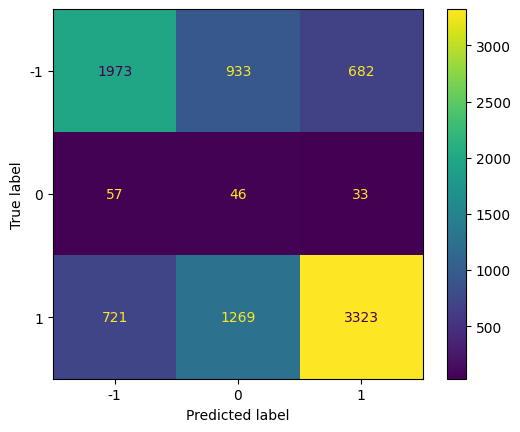

In [ ]:
cm = metrics.confusion_matrix(y_pred, y_test)
cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=[-1, 0, 1]).plot()

# SVM

In [582]:
irrelevant_columns = [
    "game_id", "season", "home_club_id", "away_club_id",
    "home_club_goals", "away_club_goals", "date"
]
df = df.drop(columns=irrelevant_columns)

In [ ]:
df.isnull().sum()

In [614]:
position = ["home_club_position", "away_club_position"]
attendance = ["attendance"]
market_value = ["home_avg_market_value", "away_avg_market_value"]
height = ["home_height", "away_height"]
last_all = ["last_5_goals_for_avg_home", "last_5_goals_against_avg_home",
            "last_5_wins_home", "last_5_ties_home", "last_5_losses_home",
            "last_5_goals_for_avg_away", "last_5_goals_against_avg_away",
            "last_5_wins_away", "last_5_ties_away", "last_5_losses_away"]
last_same = ["home_local_last_3_goals_for_avg",
             "home_local_last_3_goals_against_avg",
             "home_local_last_3_wins", "home_local_last_3_ties",
             "home_local_last_3_losses", "away_visiting_last_3_goals_for_avg",
             "away_visiting_last_3_goals_against_avg",
             "away_visiting_last_3_wins", "away_visiting_last_3_ties",
             "away_visiting_last_3_losses"]
result = ["result"]
subs = ["subs_home", "subs_away"]
cards = ["cards_home", "cards_away"]

In [640]:
keep_columns = position + market_value + result
df_ = df[keep_columns].dropna()

In [641]:
df_.shape

(1007, 5)

In [635]:
def train_svm(df_):
  X = df_.drop(columns=["result"]).to_numpy()
  y = df_["result"]
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, stratify=y)
  clf = make_pipeline(StandardScaler(), SVC(kernel="rbf"))
  clf.fit(X_train, y_train)
  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)
  train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
  test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
  return train_accuracy, test_accuracy, y_test, y_pred_test

def train_svms(df_, epochs):
  train_accuracies = []
  test_accuracies = []
  y_tests = []
  y_pred_tests = []
  for i in range(epochs):
    train_accuracy, test_accuracy, y_test, y_pred_test = train_svm(df_)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    y_tests.append(y_test)
    y_pred_tests.append(y_pred_test)
  return (np.mean(train_accuracies), np.mean(test_accuracies),
          np.array(y_tests).reshape(-1),
          np.array(y_pred_tests).reshape(-1))

In [638]:
train_acc, test_acc, y_tests, y_preds = train_svms(df_, 7)

In [639]:
metrics.accuracy_score(y_tests, y_preds)

0.6732673267326733

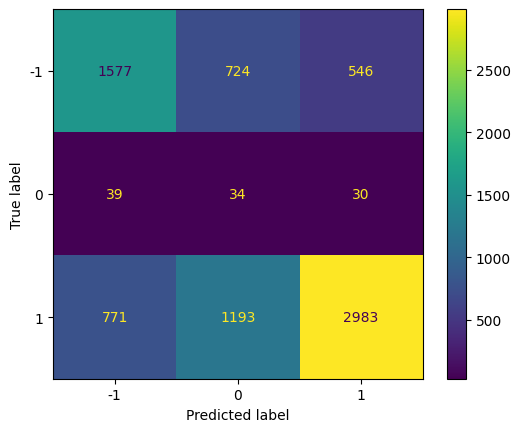

In [590]:
cm = metrics.confusion_matrix(y_pred_test, y_test)
cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=[-1, 0, 1]).plot()